In [1]:
import json
import pickle
import time
from datetime import datetime, timedelta
from itertools import product

import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import joblib
import os

import matplotlib.pyplot as plt
from tqdm import tqdm

# Local modules
import modularised_utils as mut
import opt_utils as oput
import evaluation_utils as evut
import Linear_Additive_Noise_Models as lanm
import operations as ops
import params

np.random.seed(0)

In [2]:
experiment       = 'lucas6x3'
abduction        = True
coeff_estimation = False

# Define the radius of the Wasserstein balls (epsilon, delta) and the size for both models.
epsilon, delta           = params.radius[experiment]
ll_num_envs, hl_num_envs = params.n_envs[experiment]

# Define the number of samples per environment. Currently every environment has the same number of samples
num_llsamples, num_hlsamples  = params.n_samples[experiment]

# Load ground truth abstraction
Tau = mut.load_T(experiment)

In [3]:
Dll_obs  = mut.load_samples(experiment)[None][0] 
Gll, Ill = mut.load_model(experiment, 'LL')
l        = len(Gll.nodes())

Dhl_obs  = mut.load_samples(experiment)[None][1] 
Ghl, Ihl = mut.load_model(experiment, 'HL')
h        = len(Ghl.nodes())

omega    = mut.load_omega_map(experiment)

In [4]:
if coeff_estimation == True:
    ll_coeffs = mut.get_coefficients(Dll_obs, Gll)
    hl_coeffs = mut.get_coefficients(Dhl_obs, Ghl) 
else:
    ll_coeffs = mut.load_coeffs(experiment, 'LL')
    hl_coeffs = mut.load_coeffs(experiment, 'HL')

In [5]:
if abduction == True:
    U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.lan_abduction(Dll_obs, Gll, ll_coeffs)
    U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.lan_abduction(Dhl_obs, Ghl, hl_coeffs)
else:
    U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.load_exogenous(experiment, 'LL')
    U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.load_exogenous(experiment, 'HL')

Experiment with different pertubations; i.e. different noise distributions

In [25]:
ll_loc = [1.0, -2.0, 0.5, 1.0, -2.0, 0.5]  # means for each dimension
ll_scale = [0.5, 1.0, 0.3, 0.5, 1.0, 0.3]  
hl_loc = [2, 2, 2]
hl_scale = [1, 1, 1]
lenv = ops.MultivariateLaplace(ll_loc, ll_scale)
henv = ops.MultivariateLaplace(hl_loc, hl_scale)

U_ll_hat = lenv.sample(num_llsamples)
U_hl_hat = henv.sample(num_hlsamples)

In [26]:
LLmodels = {}
for iota in Ill:
    LLmodels[iota] = lanm.LinearAddSCM(Gll, ll_coeffs, iota)
    
HLmodels, Dhl_samples = {}, {}
for eta in Ihl:
    HLmodels[eta] = lanm.LinearAddSCM(Ghl, hl_coeffs, eta)

In [29]:
def plot_progress(objs, name):
    plt.figure(figsize=(10, 6))
    plt.plot(objs, label=name)
    plt.xlabel('Iteration')
    plt.ylabel('Objective Value')
    plt.title(f'{name} Objective Progress')
    plt.legend()
    plt.show()

In [30]:
def run_empirical_optimization(U_L, U_H, L_models, H_models, epsilon, delta, eta_min, eta_max,
                                num_steps_min, num_steps_max, max_iter, tol, seed, robust_L, robust_H, initialization):
    
    torch.manual_seed(seed)
    erica = robust_L or robust_H
    # Convert inputs to torch tensors
    U_L = torch.as_tensor(U_L, dtype=torch.float32)
    U_H = torch.as_tensor(U_H, dtype=torch.float32)
    
    # Get dimensions
    N, l = U_L.shape
    _, h = U_H.shape
    
    # Initialize variables
    T     = torch.randn(h, l, requires_grad=True)
    if initialization == 'random':
        Theta = torch.randn(N, l, requires_grad=True)
        Phi   = torch.randn(N, h, requires_grad=True)

    elif initialization == 'projected':
        Theta = oput.init_in_frobenius_ball((N, l), epsilon)
        Phi   = oput.init_in_frobenius_ball((N, h), delta)

    
    # Create optimizers
    optimizer_T   = torch.optim.Adam([T], lr=eta_min)
    optimizer_max = torch.optim.Adam([Theta, Phi], lr=eta_max)
    
    prev_T_objective = float('inf')
    
    for iteration in tqdm(range(max_iter)):
         
        objs_T, objs_max = [], []
        # Step 1: Minimize with respect to T
        for _ in range(num_steps_min):
            optimizer_T.zero_grad()
            T_objective = oput.empirical_objective(U_L, U_H, T, Theta, Phi, L_models, H_models, Ill, omega)
            objs_T.append(T_objective.item())
            T_objective.backward()
            optimizer_T.step()
        #plot_progress(objs_T, 'T')
        # Step 2: Maximize with respect to Theta and Phi
        if erica == True:
            for _ in range(num_steps_max):
                optimizer_max.zero_grad()
                max_objective = -oput.empirical_objective(U_L, U_H, T, Theta, Phi, L_models, H_models, Ill, omega)
                max_objective.backward()
                optimizer_max.step()
                
                # Project onto constraint sets
                with torch.no_grad():
                    Theta.data = oput.project_onto_frobenius_ball(Theta, epsilon)
                    Phi.data = oput.project_onto_frobenius_ball(Phi, delta)

                mobj = oput.empirical_objective(U_L, U_H, T, Theta, Phi, L_models, H_models, Ill, omega)
                objs_max.append(mobj.item())

        #plot_progress(objs_max, 'max')
        # Check convergence of T's objective
        with torch.no_grad():
            current_T_objective = T_objective.item()
            if abs(prev_T_objective - current_T_objective) < tol:
                print(f"Converged at iteration {iteration + 1}")
                break
            prev_T_objective = current_T_objective
            
            # if iteration % 10 == 0:
            #     print(f"Iteration {iteration}, T Objective: {current_T_objective}")
    
    return T.detach().numpy(), Theta.detach().numpy(), Phi.detach().numpy()

In [31]:
epsilon, delta = 3, 3


In [32]:
params_erica = {
                'U_L': U_ll_hat,
                'U_H': U_hl_hat,
                'L_models': LLmodels,
                'H_models': HLmodels,
                'epsilon': epsilon,
                'delta': delta,
                'eta_min': 0.001,
                'eta_max': 0.01,
                'num_steps_min': 5,
                'num_steps_max': 5,
                'max_iter': 100,
                'tol': 1e-5,
                'seed': 23,
                'robust_L': True,
                'robust_H': True,
                'initialization': 'random'
            }

T_erica, Theta_erica, Phi_erica = run_empirical_optimization(**params_erica)

100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


In [33]:
empirical_boundary_params = {'Theta': (Theta_erica, epsilon), 'Phi': (Phi_erica, delta)}


joblib.dump(empirical_boundary_params, f"data/{experiment}/empirical_boundary_params.pkl")

['data/lucas6x3/empirical_boundary_params.pkl']

In [34]:
params_enrico = {
                'U_L': U_ll_hat,
                'U_H': U_hl_hat,
                'L_models': LLmodels,
                'H_models': HLmodels,
                'epsilon': epsilon,
                'delta': delta,
                'eta_min': 0.001,
                'eta_max': 0.01,
                'num_steps_min': 5,
                'num_steps_max': 5,
                'max_iter': 100,
                'tol': 1e-5,
                'seed': 23,
                'robust_L': False,
                'robust_H': False,
                'initialization': 'random'
            }

T_enrico, Theta_enrico, Phi_enrico = run_empirical_optimization(**params_enrico)

100%|██████████| 100/100 [00:29<00:00,  3.36it/s]


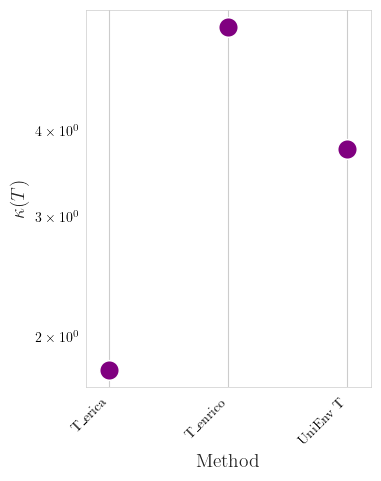

In [35]:
T_name         = ['T_erica', 'T_enrico', 'UniEnv T']
condition_nums = {}
for i, T in enumerate([T_erica, T_enrico, Tau]): 
    cn = evut.condition_number(T)
    condition_nums[T_name[i]] = cn
evut.plot_condition_nums(condition_nums)

In [36]:
data = mut.load_samples(experiment)

In [40]:
add_pertL          = True
add_pertH          = True
pert_typeL         = 'random_normal'
pert_typeH         = 'random_normal'

lin_contaminationL = False
lin_contaminationH = False
cont_type          = 'huber'
cont_fracL         = .9
cont_fracH         = .6

metric             = 'fro'
num_iter           = 100

100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


Average e(τ) for ERiCA: 32.79 ± 0.526

Average e(τ) for ENRiCO: 33.48 ± 0.515

Average e(τ) for UniEnv: 45.11 ± 1.592



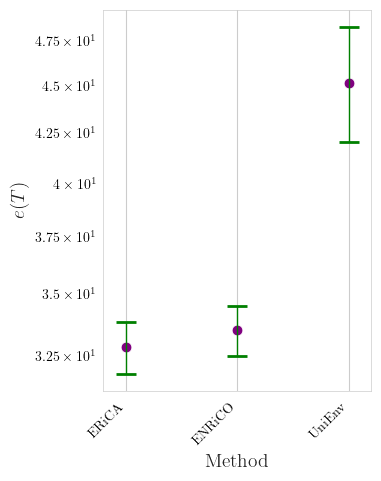

In [41]:
method_names      = ['ERiCA', 'ENRiCO', 'UniEnv']
methods           = [T_erica, T_enrico, Tau]
abstraction_error = {name: [] for name in method_names}

# Outer loop: number of noise sampling iterations
for iter_num in tqdm(range(num_iter)): # desc="Noise sampling iterations"

    pert_L = evut.generate_pertubation(data[None][0], pert_typeL, 'Theta', experiment)
    pert_H = evut.generate_pertubation(data[None][1], pert_typeH, 'Phi', experiment)
    
    # For this noise iteration, evaluate each method
    for i, T in enumerate(methods):
        total = 0
        # Compute average error over Ill for this method
        for iota in Ill:
            # Get base data and add noise
            base, abst = data[iota]
            
            if add_pertL:
                base = base + pert_L # + base 
            if add_pertH:
                abst = abst + pert_H # + abst
                
            if lin_contaminationL:
                base  = evut.contaminate_linear_relationships(base, contamination_fraction=cont_fracL, contamination_type=cont_type)
            if lin_contaminationH:
                abst  = evut.contaminate_linear_relationships(abst, contamination_fraction=cont_fracH, contamination_type=cont_type)
            base_norm = base / np.linalg.norm(base, 'fro')
            abst_norm = abst / np.linalg.norm(abst, 'fro')
            # Apply method and compute distance
            tau_base = base @ T.T
            if metric == 'fro':
                dist     = ops.MatrixDistances.frobenius_distance(tau_base, abst)
            elif metric == 'sq_fro':
                dist     = ops.MatrixDistances.squared_frobenius_distance(tau_base, abst)
            elif metric == 'nuclear':
                dist     = ops.MatrixDistances.nuclear_norm_distance(tau_base, abst)
            elif metric == 'spectral':
                dist     = ops.MatrixDistances.spectral_norm_distance(tau_base, abst)
            elif metric == 'l1':
                dist     = ops.MatrixDistances.l1_distance(tau_base, abst)    
            else:
                raise ValueError(f"Invalid metric: {metric}")
                
            total   += dist
            
        iter_avg = total / len(Ill)
        abstraction_error[method_names[i]].append(iter_avg)

final_abstraction_error = {}
for name in method_names:
    mean_e = np.mean(abstraction_error[name])
    std_e = np.std(abstraction_error[name])
    final_abstraction_error[name] = (mean_e/100, std_e * 1.96)
    print(f"Average e(τ) for {name}: {mean_e/100:.2f} ± {std_e:.3f}\n")

evut.plot_abstraction_error(final_abstraction_error)

In [ ]:


# Modified loop with Huber contamination
for iter_num in tqdm(range(num_iter)):
    noiseL = evut.generate_noise(data[None][0], noise_typeL, 'L', experiment, normalize=True, random_range=noise_range)
    noiseH = evut.generate_noise(data[None][1], noise_typeH, 'H', experiment, normalize=True, random_range=noise_range)
    
    # For this noise iteration, evaluate each method
    for i, T in enumerate(methods):
        total = 0
        # Compute average error over Ill for this method
        for iota in Ill:
            # Get base data and add noise
            base, abst = data[iota]
            
            if add_noiseL:
                base = base + noiseL
            if add_noiseH:
                abst = abst + noiseH
                
            if lin_contaminationL:
                if cont_type == 'huber':
                    base = contaminate_huber(base, contamination_fraction=cont_fracL)
                else:
                    base = evut.contaminate_linear_relationships(base, contamination_fraction=cont_fracL, contamination_type=cont_type)
                    
            if lin_contaminationH:
                if cont_type == 'huber':
                    abst = contaminate_huber(abst, contamination_fraction=cont_fracH)
                else:
                    abst = evut.contaminate_linear_relationships(abst, contamination_fraction=cont_fracH, contamination_type=cont_type)
            
            base_norm = base / np.linalg.norm(base, 'fro')
            abst_norm = abst / np.linalg.norm(abst, 'fro')
            
            # Apply method and compute distance
            tau_base = base @ T.T
            dist = ops.MatrixDistances.frobenius_distance(tau_base, abst)
                
            total += dist
            
        # Store average error for this method in this iteration
        iter_avg = total / len(Ill)
        abstraction_error[method_names[i]].append(iter_avg)

In [ ]:

# Visualize results
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plot first variable distribution
plt.subplot(131)
for i, dist in enumerate(distributions):
    plt.hist(dist[:, 0], bins=30, alpha=0.3, label=f'Dist {i+1}')
plt.hist(bary_exact[:, 0], bins=30, alpha=0.5, color='red', label='Barycenter')
plt.title('First Variable Distribution')
plt.legend()

# Plot 2D projection
plt.subplot(132)
for dist in distributions:
    plt.scatter(dist[:, 0], dist[:, 1], alpha=0.1)
plt.scatter(bary_exact[:, 0], bary_exact[:, 1], 
            color='red', alpha=0.5, label='Barycenter')
plt.title('2D Projection (vars 0 and 1)')
plt.legend()

# Compare exact vs approximate
plt.subplot(133)
plt.scatter(bary_exact[:, 0], bary_exact[:, 1], 
            alpha=0.5, label='Exact')
plt.scatter(bary_approx[:, 0], bary_approx[:, 1], 
            alpha=0.5, label='Approximate')
plt.title('Exact vs Approximate Barycenter')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
def compute_empirical_distribution(data, num_bins=10):
    """
    Compute the empirical distribution for each variable in a dataset.

    Parameters:
        data (numpy.ndarray): Dataset of shape (num_samples, num_variables).
        num_bins (int): Number of bins for the histogram.

    Returns:
        dict: A dictionary where each key is the variable index (0-based) and each value
              is a vector of probabilities corresponding to the bins.
    """
    if not isinstance(data, np.ndarray):
        raise ValueError("Input data must be a numpy array.")
    
    num_variables = data.shape[1]
    empirical_distributions = {}

    for i in range(num_variables):
        variable_data = data[:, i]  # Extract data for one variable
        hist, bin_edges = np.histogram(variable_data, bins=num_bins, density=True)  # Density=True gives probabilities
        empirical_distributions[i] = hist  # Store the probabilities as a vector

    return empirical_distributions


In [38]:
num_samples = 100
num_variables = 3
example_data = np.random.randn(num_samples, num_variables)  # Replace with your dataset

distributions = compute_empirical_distribution(base, num_bins=10)

# Print the empirical distribution for each variable
for var_index, dist in distributions.items():
    print(f"Variable {var_index}:")
    print(f"  Probabilities: {dist}")
    print()

Variable 0:
  Probabilities: [3.39452803e-04 6.21965136e-03 5.40824966e-02 2.06518705e-01
 3.76058955e-01 3.12690782e-01 1.17330219e-01 2.00167653e-02
 1.67536384e-03 7.66506330e-05]

Variable 1:
  Probabilities: [0.00043555 0.00503171 0.04011616 0.15979986 0.3327349  0.35362969
 0.19120508 0.05393904 0.00869948 0.00058455]

Variable 2:
  Probabilities: [3.45294686e-04 5.64723890e-03 4.34180221e-02 1.78896063e-01
 3.56477779e-01 3.35648712e-01 1.54614050e-01 3.48859018e-02
 3.65344055e-03 2.67324918e-04]



In [21]:
a = compute_empirical_distribution(base[None])

In [45]:
def compute_empirical_distribution(data: np.ndarray, num_bins: int = 50) -> tuple:
    """
    Compute the empirical distribution for each variable in a dataset using binning.

    Parameters:
        data (numpy.ndarray): Dataset of shape (num_samples, num_variables).
        num_bins (int): Number of bins to use for discretization.

    Returns:
        tuple: (binned_distribution, bin_edges)
            - binned_distribution: array of shape (num_bins, num_variables) containing the normalized histogram
            - bin_edges: list of arrays containing bin edges for each variable
    """
    if not isinstance(data, np.ndarray):
        raise ValueError("Input data must be a numpy array.")
    
    num_samples, num_variables = data.shape
    binned_distribution = np.zeros((num_bins, num_variables))
    bin_edges = []
    
    # Process each variable separately
    for var_idx in range(num_variables):
        # Compute bin edges for equal-width partitioning
        var_min = data[:, var_idx].min()
        var_max = data[:, var_idx].max()
        edges = np.linspace(var_min, var_max, num_bins + 1)
        bin_edges.append(edges)
        
        # Compute histogram for this variable
        hist, _ = np.histogram(data[:, var_idx], bins=edges, density=True)
        binned_distribution[:, var_idx] = hist
    
    # Normalize the binned distribution
    binned_distribution = binned_distribution / np.sum(binned_distribution, axis=0)
    
    return binned_distribution, bin_edges

In [69]:
dist, edges = compute_empirical_distribution(base, num_bins=15)

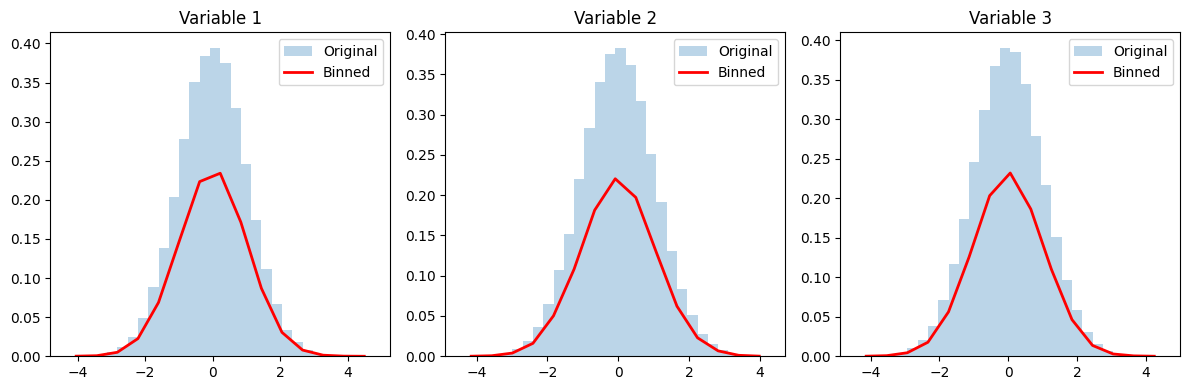

In [70]:
plt.figure(figsize=(12, 4))
    
# Plot distributions for each variable
for var_idx in range(3):
    plt.subplot(1, 3, var_idx + 1)
    
    # Plot original data histogram
    plt.hist(base[:, var_idx], bins=30, alpha=0.3, density=True, label='Original')
    
    # Plot binned distribution
    bin_centers = (edges[var_idx][1:] + edges[var_idx][:-1]) / 2
    plt.plot(bin_centers, dist[:, var_idx], 'r-', label='Binned', linewidth=2)
    
    plt.title(f'Variable {var_idx + 1}')
    plt.legend()

plt.tight_layout()
plt.show()

In [72]:
edges

[array([-4.34369039, -3.73486741, -3.12604443, -2.51722145, -1.90839848,
        -1.2995755 , -0.69075252, -0.08192954,  0.52689344,  1.13571642,
         1.74453939,  2.35336237,  2.96218535,  3.57100833,  4.17983131,
         4.78865429]),
 array([-4.44707181, -3.86542757, -3.28378334, -2.70213911, -2.12049488,
        -1.53885065, -0.95720642, -0.37556218,  0.20608205,  0.78772628,
         1.36937051,  1.95101474,  2.53265897,  3.11430321,  3.69594744,
         4.27759167]),
 array([-4.42929415, -3.83077157, -3.23224899, -2.6337264 , -2.03520382,
        -1.43668124, -0.83815866, -0.23963608,  0.3588865 ,  0.95740908,
         1.55593166,  2.15445424,  2.75297682,  3.3514994 ,  3.95002198,
         4.54854457])]

In [44]:

distribution = compute_empirical_distribution(base)

# Print the uniform empirical distribution
print("Empirical Distribution:")
print(distribution)

Empirical Distribution:
{0: array([3.1000e-04, 5.6800e-03, 4.9390e-02, 1.8860e-01, 3.4343e-01,
       2.8556e-01, 1.0715e-01, 1.8280e-02, 1.5300e-03, 7.0000e-05]), 1: array([0.00038, 0.00439, 0.035  , 0.13942, 0.2903 , 0.30853, 0.16682,
       0.04706, 0.00759, 0.00051]), 2: array([3.1000e-04, 5.0700e-03, 3.8980e-02, 1.6061e-01, 3.2004e-01,
       3.0134e-01, 1.3881e-01, 3.1320e-02, 3.2800e-03, 2.4000e-04])}
